Before iteration 1 loss is 18592149504.0
Before iteration 2 loss is 16753486848.0
Before iteration 3 loss is 16095247360.0
Before iteration 4 loss is 15335306240.0
Before iteration 5 loss is 14527073280.0
Before iteration 6 loss is 13709532160.0
Before iteration 7 loss is 12921452544.0
Before iteration 8 loss is 12189776896.0
Before iteration 9 loss is 11532129280.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Before iteration 10 loss is 10959335424.0


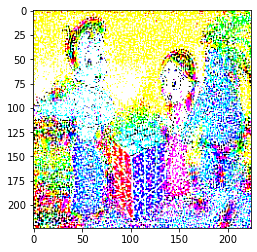

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras import Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
import pprint

base_model = VGG16(weights='imagenet')
content_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_conv2').output, trainable=False)

STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

alpha = 10
beta = 40
STYLE_MODELS = [Model(inputs=base_model.input, outputs = base_model.get_layer(model).output, trainable=False) for model, weight in STYLE_LAYERS]
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
COLOR_CHANNELS = 3

def plot_image(img):
  if len(img.shape) > 3:
    img = tf.squeeze(img, axis=0)
  plt.imshow(img)

def save(image, out="output.png"):
  if len(image.shape)>3:
    image = tf.squeeze(image, axis=0)
  image = np.clip(image.numpy(), 0, 255).astype('uint8')
  imageio.imwrite(out, image)

def clip(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255.0)

def content_cost(a_G, a_C):
  m, n_H, n_W, n_C = a_G.shape
  a_C_unrolled = tf.reshape(a_C, shape=[m, -1, n_C])
  a_G_unrolled = tf.reshape(a_G, shape=[m, -1, n_C])

  J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))/(4*n_H*n_W*n_C)
  
  return J_content

def style_cost(a_S, a_G):
  m, n_H, n_W, n_C = a_G.shape

  a_S = tf.transpose(tf.reshape(a_S, shape=[n_H*n_W, n_C]))
  a_G = tf.transpose(tf.reshape(a_G, shape=[n_H*n_W, n_C]))
  GS = gram_matrix(a_S)
  GG = gram_matrix(a_G)
  J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG)))/(4*n_C*n_C*n_H*n_H*n_W*n_W)

  return J_style_layer

def get_style_cost(style_dict, orig_style):
  cost = 0
  for (layer, weight), model in zip(STYLE_LAYERS, STYLE_MODELS):
    a_S = orig_style[layer]
    a_G = style_dict[layer]
    cost += weight*style_cost(a_S, a_G)
  
  return cost

def get_outputs(generated):
  output = {"content": content_model(generated)}
  output["orig_content"] = content_model(content_image)
  style = {}
  style_orig = {}
  for (layer, weight), model in zip(STYLE_LAYERS, STYLE_MODELS):
    style[layer] = model(generated)
    style_orig[layer] = model(style_image)
  output["style"] = style
  output["orig_style"] = style_orig
  return output

@tf.function()
def train_step(tensor):
  with tf.GradientTape() as tape:
    outputs = get_outputs(tensor)
    loss = get_cost(outputs)

  grads = tape.gradient(loss, tensor)
  optimizer.apply_gradients([(grads, tensor)])
  tensor.assign(clip(tensor))
  return loss

def generate_noise_image(content_image, noise_ratio = 0.6):
  noise_image = np.random.uniform(-20, 20, (1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)).astype('float32')
  input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
  input_tensor = tf.Variable(input_image, dtype=tf.float32)
  return input_tensor

def gram_matrix(A):
  return tf.matmul(A, tf.transpose(A))

def get_cost(outputs):
  content_repr = outputs["content"]
  orig_content = outputs["orig_content"]
  style_dict = outputs["style"]
  orig_style = outputs["orig_style"]
  return alpha*content_cost(content_repr, orig_content) + beta*get_style_cost(style_dict, orig_style)

def main_loop(content_image_path, style_image_path, iterations=10):
  global content_image, style_image, optimizer
  img = image.load_img(content_image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
  content_image = image.img_to_array(img)
  content_image = np.expand_dims(content_image, axis=0)
  content_image = tf.constant(preprocess_input(content_image))

  img = image.load_img(style_image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
  style_image = image.img_to_array(img)
  style_image = np.expand_dims(style_image, axis=0)
  style_image = tf.constant(preprocess_input(style_image))

  generated = generate_noise_image(content_image)
  outputs = get_outputs(generated)
  optimizer = tf.keras.optimizers.Adam(2.0)

  for count in range(iterations):
    print ("Before iteration {0} loss is {1}".format(count+1, train_step(generated)))    

  plot_image(generated.numpy())
  save(generated.numpy())
  

main_loop('bheem.jpg', 'style1.jpg')